Необходимые данные находятся в таблицах схемы `stackoverflow`. подключение к архиву БД Stackoverflow с помощью SQLAlchemy. 

Некоторые задания включают дополнительные вопросы. На часть вопросов можно ответить текстом, а для некоторых понадобится визуализация.

#  Конфигурация для подключения к базе данных 

База данных  `data-analyst-advanced-sql` содержит схему `stackoverflow`, с которой будем работать в проекте

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import calendar
from sqlalchemy import create_engine 

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

Пример запроса к базе данных

`sample_df` является pandas-датафреймом.

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


## Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [6]:
# напишите запрос
query = '''
SELECT DISTINCT CAST(DATE_TRUNC('month',creation_date)as date ) as month_date, 
    sum(views_count) OVER (PARTITION BY CAST(DATE_TRUNC('month',creation_date)as date ) )
FROM stackoverflow.posts
ORDER BY 2 DESC
'''

# выполните запрос
df_1 = pd.read_sql_query(query, con=engine) 
df_1

,month_date,sum
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


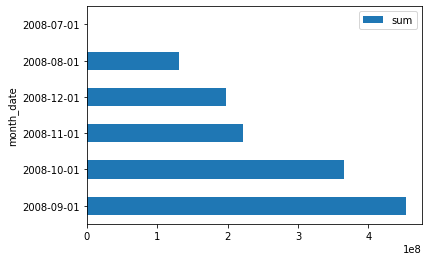

In [7]:
df_1.plot.barh(x="month_date", y="sum")
plt.show()

###  Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

Данные представлены фактически с августа по декабрь ( за июль только один неполный день). Резкий рост просмотров в сентябре  предположительно связан с очень актуальным и/или интересными постом (постами). В октябре предположительно присутсвуют "отголосикх" этих постов и прододение их просмотров и/или обсуждение. 

## Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [9]:
query = '''
SELECT display_name as name , count(distinct p.user_id)
FROM  stackoverflow.posts as p
JOIN stackoverflow.post_types as pt on p.post_type_id = pt.id
JOIN stackoverflow.users as u on p.user_id = u.id
WHERE type = 'Answer' and  CAST(DATE_TRUNC('day',p.creation_date)as date ) <= (u.creation_date + interval '1' month)
GROUP BY 1
HAVING count (type) >  100
'''

df_2_1 = pd.read_sql_query(query, con=engine) 
df_2_1.head(15)

,name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
5,Amy B,1
6,Ben Hoffstein,1
7,Brian,15
8,Cade Roux,1
9,CesarB,1


Некторые имена неоднократно встречаются среди самых активных. Например имя Chris достаточно популярно. Так же можно выделить Jon Skeet ( id =22656) и Joel Coehoorn (id = 3043), давших 387 и 306 ответов за первый месяц после регистрации соответсвенною Видимо очень знающие товарищи. но необходимо проверить рекацию на их ответы. Может в них не очень много пользы. 

## Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [10]:
# напишите запрос
query = '''
SELECT CAST(DATE_TRUNC('month',p.creation_date)as date ) as month, count (id) as posts
FROM stackoverflow.posts as p
WHERE p.user_id in (
SELECT u.id
FROM stackoverflow.users as u
JOIN  stackoverflow.posts as p on u.id = p.user_id
WHERE CAST(DATE_TRUNC('day',u.creation_date)as date )  between '2008-09-01' and '2008-09-30'
and CAST(DATE_TRUNC('day',p.creation_date)as date )  between '2008-12-01' and '2008-12-31' )
GROUP BY 1
ORDER BY 1 DESC

'''

# выполните запрос

df_3 = pd.read_sql_query(query, con=engine) 
df_3

,month,posts
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


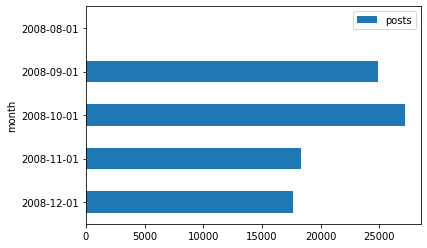

In [11]:
df_3.plot.barh(x="month", y="posts")
plt.show()

### Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

Так же как и в первом задании сентябрь и октябрь ( на основании представленных данных) сильно вырываются вперед. Вероятно количество просмотров было связано не только с качественными, но и с количественными  показателями публикаций. Количество постов в августе аномально мало. Но тк мы отбираем только пользователей которые зарегистрировались в сентябре, не стоило от них ожидать активного "прочёсывания" архивов.

## Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [12]:
# напишите запрос
query = '''

SELECT user_id, creation_date,views_count, 
    sum (views_count) OVER (PARTITION BY user_id ORDER BY creation_date)  as cumulative_count
FROM stackoverflow.posts
ORDER BY 1,2
'''

# выполните запрос
df_4 = pd.read_sql_query(query, con=engine) 
df_4

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


## Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [13]:
# напишите запрос
query = '''
WITH first as (SELECT user_id, count(creation_date) as total
FROM stackoverflow.posts
where CAST(DATE_TRUNC('month',creation_date)as date ) = '2008-08-01' 
GROUP BY 1
HAVING count (creation_date) > 120 ),

second as (SELECT  user_id,CAST(DATE_TRUNC('day', creation_date)as date) as days , count(id)
FROM first 
LEFT JOIN stackoverflow.posts using (user_id)
WHERE CAST(DATE_TRUNC('day', creation_date)as date ) between '2008-08-01' and '2008-08-31'
GROUP BY 2,1
ORDER BY 2)

SELECT user_id, avg (count) as avg_daily
FROM second
GROUP BY 1
ORDER BY 2


'''

# выполните запрос

df_5 = pd.read_sql_query(query, con=engine) 
df_5

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


## Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

In [14]:
# напишите запрос
query = '''

with first as (
SELECT user_id,count (DISTINCT CAST( DATE_TRUNC('day', creation_date)as date) )as days 
FROM stackoverflow.posts
where CAST(DATE_TRUNC('day',creation_date)as date ) between '2008-12-01' and '2008-12-07' 
GROUP BY 1
)

select round(avg (days))  as result
from first


'''

# выполните запрос
df_6 = pd.read_sql_query(query, con=engine) 
df_6

,result
0,2.0


### Проанализируйте итоговую таблицу — какие выводы можно сделать?

В среднем взамодействие происходит 2 дня . Возможно большинство пользотвателей заходит на платформу только в выходные.

## Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [15]:
# напишите запрос
query = '''
SELECT user_id,creation_date,LAG (TO_CHAR(creation_date, 'Month'),2) OVER (PARTITION BY user_id ORDER BY creation_date) AS second_last_month 
FROM stackoverflow.posts

'''

# выполните запрос

df_7 = pd.read_sql_query(query, con=engine) 
df_7

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


## Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [16]:
# напишите запрос
query = '''
WITH profile AS
  (SELECT user_id, CAST(DATE_TRUNC('month',min(creation_date) )as date ) as cohort_dt
   FROM stackoverflow.posts
   GROUP BY 1), 
sessions AS
  (SELECT user_id,
          CAST(DATE_TRUNC('month',creation_date)as date ) AS session_dt
   FROM stackoverflow.posts
   JOIN profile using (user_id)
   GROUP BY 1,2),
cohort_users_cnt AS
  (SELECT cohort_dt,
          COUNT(user_id) AS cohort_users_cnt
   FROM profile
   GROUP BY 1)

SELECT cohort_dt, session_dt, count(profile.user_id) as users_cnt, cohort_users_cnt, ROUND(COUNT(profile.user_id) * 100.0 / cohort_users_cnt, 2) as retention_rate
 FROM profile
 join sessions using (user_id)
 join cohort_users_cnt using (cohort_dt)
 group by 1,2,4   

'''

# выполните запрос

df_8 = pd.read_sql_query(query, con=engine) 

df_8

,cohort_dt,session_dt,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


### Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

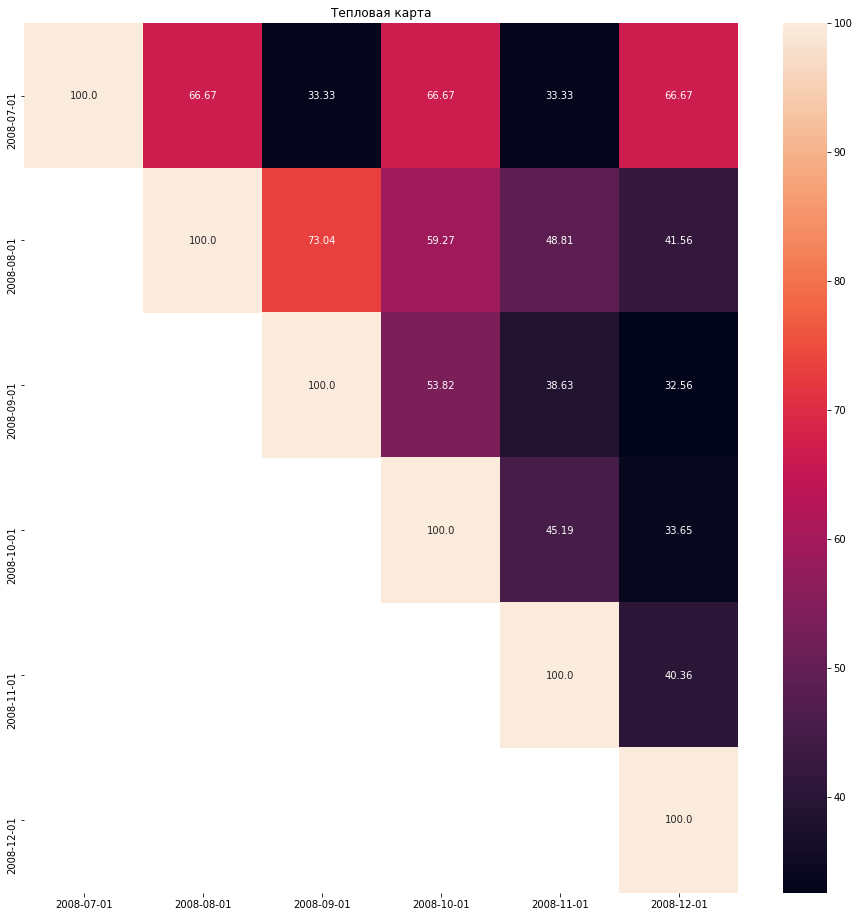

In [17]:
# строим тепловую карту Retention Rate

retention = df_8.pivot('cohort_dt', 'session_dt', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

# строим хитмэп
plt.figure(figsize=(16, 16)) # задаём размер графика
sns.heatmap(retention, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show() 



- Поведение всех когорт кроме июльской при первом взгляде является нормальным (плавно убывающим)
- Для июльской когорты являются аномальными "прыгающие" значения (66-33-66-33-66). Но в связи с тем, что мы получили далеко не полные данные за июль и расчетный размер когорты - всего 3 человека, нельзя полноценно судить о поведении этой группы. Необходимо больше данных  для анализа.

## Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

In [18]:
# напишите запрос
query = '''
SELECT CAST (EXTRACT (month FROM creation_date) as int) as creation_month, count (id) as posts_count,  round(
    (
        (count (id)::numeric / LAG(count (id)) OVER (ORDER BY CAST (EXTRACT (month FROM creation_date) as int) )
        ) - 1) * 100,2)  as percentage
FROM stackoverflow.posts
WHERE EXTRACT (month FROM creation_date) between 9 and 12
GROUP BY 1

'''

# выполните запрос

df_9 = pd.read_sql_query(query, con=engine) 
df_9

,creation_month,posts_count,percentage
0,9,70371,NaN
1,10,63102,-10.33
2,11,46975,-25.56
3,12,44592,-5.07


### Постройте круговую диаграмму с количеством постов по месяцам.

In [19]:
df_9['month'] = df_9['creation_month'].apply(lambda x: calendar.month_name[x])
df_9


,creation_month,posts_count,percentage,month
0,9,70371,NaN,September
1,10,63102,-10.33,October
2,11,46975,-25.56,November
3,12,44592,-5.07,December


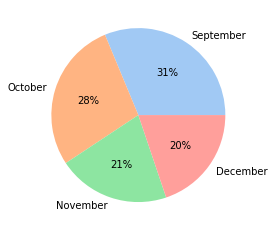

In [20]:
# постройте круговую диаграмму с количеством постов по месяцам
colors = sns.color_palette('pastel')[0:4]
plt.pie(df_9['posts_count'], labels =df_9['month'],colors = colors,  autopct='%.0f%%')
plt.show()

Количество постов с каждым месяцем снижается.Однако темп снижения в декабре существенно снизился.

## Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [21]:
# напишите запрос
query = '''
SELECT  DISTINCT CAST(EXTRACT (week FROM cast(creation_date as date)) as int) as week_creation, 
MAX (creation_date) OVER (PARTITION BY EXTRACT (week FROM cast(creation_date as date))) as creation_date
FROM stackoverflow.posts
WHERE EXTRACT (month FROM creation_date) = 10
and user_id in (
SELECT user_id 
FROM (
SELECT user_id, count (id) as posts_count  
FROM stackoverflow.posts
GROUP BY 1
ORDER BY 2 DESC
LIMIT 1) 
as first)

'''

# выполните запрос
df_10 = pd.read_sql_query(query, con=engine) 
df_10

,week_creation,creation_date
0,40,2008-10-05 09:00:58
1,41,2008-10-12 21:22:23
2,42,2008-10-19 06:49:30
3,43,2008-10-26 21:44:36
4,44,2008-10-31 22:16:01


##  Вывод 

Для проведения анализа поведения пользователей было осуществлено подключение к архиву базы данных сайта Stackoverflow с помощью SQLAlchemy.
В ходе исследования определили: 
- общую сумму просмотров постов за каждый месяц 2008 года
- имена самых активных пользователей, и самые часто втречающиеся имена среди них
- количество постов за 2008 год по месяцам, от пользователей, которые зарегистрировались в сентябре 2008 года
- детализировано количество просмотров у поста / сумма просмотров постов автора с накоплением в течении времени
- среднее количество постов пользователей в день за август 2008 года
- среднее количество дней взаимодействия с платформой в период с 1 по 7 декабря 2008 года 
- историю активности каждого пользователя
- Retention Rate по месяцам для пользователей StackOverflow так же представили эту метрику в графическом виде
- относительное изменение количества постов ежемесячно с 1 сентября по 31 декабря 2008 года, так же эта информация представлена на круговой диаграмме 
- данные активности пользователя, который опубликовал больше всего постов за всё время.

Итоги:
среди на соновании представленных данных можем сделать следующие выводы:
- больше всего простмотров за сентябрь 2008
- наиболе часто всречаются имена Chris и Matt
- больше всего постов создано в октябре 2008
- самый просматриваемый - пост от 2008-12-08 18:14:26 от пользователя Ray Vega
- в среднем за август 2008 года активные пользователи публикуют более 4,7 постов в день
- в среднем взамодействие с платформой происходит 2 дня
- Retention Rate (интерес к платформе) находится на примелемом уровне. 
- количество новых постов в ноябре сократилось н ачетверть по сравнению с октябрем